## Example: Graph (small molecule) data

For this example, we'll fit a model to predict atomization energy on
the QM9 dataset, a widely used benchmark for this task with about 134,000
molecules. The dataset needs some preprocessing to convert into
a format we can use. We'll need the ase library to be
installed for this.

Molecules are a common form of graph data, and we can of course represent
them in a variety of ways. Here we'll use a very simple approach: one-hot
encode each atom type and weight it based on distance to a central atom.
We then use a graph convolution kernel to pairwise compare all atomic
environments in any two molecules.

This is a *very* crude way to represent a molecule that discards a lot of information.
Using more sophisticated
representations, we can achieve performance competitive with state
of the art. What's interesting about this simple representation,
however, is that it can already achieve surprisingly good performance,
with a mean absolute error of about 1 kcal / mol (the so-called
"chemical accuracy" threshold), despite its simplicity, nicely
demonstrating the usefulness of graph convolution kernels.

All experiments here are using xGPR v0.3.2.

In [1]:
import os
import shutil
import time
import tarfile
import wget
import ase
from ase.io import read
import subprocess
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix

from xGPR import xGPRegression as xGPReg
from xGPR import build_regression_dataset

/ssd1/Documents/gp_proteins/venv_testing/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The next step retrieves the raw data. QM9 is fairly large, so this will take a minute...

In [2]:
#Retrieving the raw data -- this might take a minute...
qm9_yvals_url = "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv"
qm9_xyz_url = "https://figshare.com/ndownloader/files/3195389"
fname = wget.download(qm9_yvals_url)
fname = wget.download(qm9_xyz_url)
tarball = tarfile.open(fname)
tarball.extractall("qm9_mols")
os.remove(fname)

#We have to clean up the downloaded files a little.
os.chdir("qm9_mols")
for f in os.listdir():
    with open(f, "r") as fhandle:
        raw_file = fhandle.readlines()
    raw_file = [l.replace("*^", "e") for l in raw_file]
    with open(f, "w+") as fhandle:
        for line in raw_file[:-3]:
            fhandle.write(line)

os.chdir("..")

100% [........................................................................] 86144227 / 86144227

In [3]:
os.chdir("qm9_mols")
xfiles = [os.path.abspath(f) for f in os.listdir()]
xfiles.sort()

#The common practice for this in the literature
#has been to use 110,000 mols for training,
#remainder for test & validation. We'll follow
#that here.
random.seed(123)
random.shuffle(xfiles)

train_x, test_x = xfiles[:110000], xfiles[110000:]

os.chdir("..")

labels = pd.read_csv("qm9.csv")
mol_dict = { k.split("_")[-1]:v for (k,v) in zip(labels.mol_id.tolist(), labels.u298_atom.tolist())} 

Here we encode each molecule as a matrix where each row is one atom; the features
in that row are one-hot encodings of all other atoms (out to the nearest 15)
weighted by how far away they are, using 1/r**6 weighting (this is
used to construct a London matrix, which is why we use it here).
This could easily be optimized for faster feature generation if desired,
but again, our goal here is merely a simple demonstration. Notice that just as
for sequences, we record the "sequence length" (i.e. number of nodes in the graph)
for each molecule. This way, xGPR can mask the zero-padding we add to the end of
each graph so that all are the same length. If we set the sequence length to be the
same for every datapoint, however, then the zero-padding is not masked. In general, it's usually preferable to mask
zero-padding, unless the size of an input communicates some useful information about that datapoint.

In [4]:
def encode_mols(x_file_list, y_value_dict, chunk_size, ftype = "train"):
    x_batch, y_batch, seqlen_batch = [], [], []
    fcounter = 0

    atom_key = {"H":0, "C":1, "O":2, "N":3, "F":4}
    num_atom_types = len(atom_key)
    max_partners = 15
    
    for xfile in x_file_list:
        #Each molecule has up to 29 atoms
        output_mat = np.zeros((29, num_atom_types * max_partners), dtype=np.float32)

        mol = read(xfile)
        f_key = str(int(xfile.split("_")[-1].split(".xyz")[0]))
        y_batch.append(y_value_dict[f_key])

        positions, symbols = mol.get_positions(), mol.get_chemical_symbols()
        dist_mat = distance_matrix(positions, positions)
        idx_by_dist = np.argsort(dist_mat, axis=1)

        for i, symbol in enumerate(symbols):
            #One-hot encode the central atom
            output_mat[i,atom_key[symbol]] = 1
            for j, idx in enumerate(idx_by_dist[i,1:max_partners].tolist()):
                atom_offset = (j + 1) * num_atom_types + atom_key[symbols[idx]]
                output_mat[i, atom_offset] = 1 / dist_mat[i,idx]**6

        x_batch.append(output_mat)
        seqlen_batch.append(len(symbols))
        
        if len(x_batch) >= chunk_size:
            np.save(f"{ftype}_{fcounter}_xbatch.npy", np.stack(x_batch))
            np.save(f"{ftype}_{fcounter}_ybatch.npy", np.asarray(y_batch))
            np.save(f"{ftype}_{fcounter}_seqlen.npy", np.array(seqlen_batch))
            x_batch, y_batch, seqlen_batch = [], [], []
            fcounter += 1

In [5]:
#We now encode all the raw data...this might take a minute.
encode_mols(train_x, mol_dict, chunk_size = 1000, ftype="train")
encode_mols(test_x, mol_dict, chunk_size = 1000, ftype="test")

In [6]:
train_x_files = [f for f in os.listdir() if f.startswith("train") and f.endswith("xbatch.npy")]
test_x_files = [f for f in os.listdir() if f.startswith("test") and f.endswith("xbatch.npy")]

train_y_files = [f.replace("xbatch", "ybatch") for f in train_x_files]
test_y_files = [f.replace("xbatch", "ybatch") for f in test_x_files]

train_seqlen_files = [f.replace("xbatch", "seqlen") for f in train_x_files]
test_seqlen_files = [f.replace("xbatch", "seqlen") for f in test_x_files]

Notice how we supply a third argument -- the list of files containing sequence lengths -- here. The third
argument defaults to None, which is what we would supply if using a fixed-length vector kernel. For
3d array data (sequences, graphs) by contrast, the third argument (sequence / graph lengths) is required.
The chunk size just has to be an integer larger than the largest file in the dataset; the dataset builder
will just check to make sure all our files contain <= that number of datapoints.

In [7]:
train_dset = build_regression_dataset(train_x_files, train_y_files, train_seqlen_files, chunk_size = 1000)

We'll use GraphRBF as the kernel, a convolution kernel with a conv_width of 1 which just does pairwise comparisons between all the nodes in any two graphs. This is generally faster than the sequence convolution kernels but slower than Matern or RBF. As we did before, we'll use ``tune_hyperparams_crude`` to get a rough idea
of where "good" hyperparameters are located and compare different kernels (if needed), then fine-tune.
The GraphRBF kernel has a kernel setting we can use, "averaging", which is one of 'none' (default), 'sqrt', 'full'.
See the available kernels page for more on what these do.

In [8]:
init_model = xGPReg(num_rffs = 1024, variance_rffs = 512,
                   kernel_choice = "GraphRBF", verbose = True,
                   device = "gpu", kernel_settings={"averaging":'none'})

best_hparams, _, best_score = init_model.tune_hyperparams_crude(train_dset)

Grid point 0 acquired.
Grid point 1 acquired.
Grid point 2 acquired.
Grid point 3 acquired.
Grid point 4 acquired.
Grid point 5 acquired.
Grid point 6 acquired.
Grid point 7 acquired.
Grid point 8 acquired.
Grid point 9 acquired.
New hparams: [0.9146764]
Additional acquisition 10.
New hparams: [0.0392626]
Additional acquisition 11.
New hparams: [0.400479]
Additional acquisition 12.
New hparams: [0.4277992]
Best score achieved: -283592.346
Best hyperparams: [-5.0470805  0.400479 ]


Now let's fine tune this using more random features. We could use the built-in
``model.tune_hyperparams`` as we did in the tabular data example or use Optuna as we did
in the sequence example. Or we could just do simple grid search in the region around
the best hyperparameters identified so far. For illustrative purposes here, we'll
do a simple grid search.

One helpful thing to keep in mind: We know this data is nearly noise-free, and the fact
that crude tuning selected a small value for the first hyperparameter (lambda_) suggests
we don't need much regularization, so optimal values for lambda_ are probably going to be
small (depending on what sigma is). We don't usually want to set lambda_ to much below -6.91 (log_e (1e-3)) for numerical
stability reasons. These considerations will help us with our search.

In [12]:
lambda_grid = [-6.25, -6., -5.5]
sigma_grid = [0., 0.25, 0.5, 0.75, 1, 1.5]

nmll_grid = np.zeros((len(lambda_grid), len(sigma_grid)))

init_model.num_rffs = 4096

for i, lambda_ in enumerate(lambda_grid):
    for j, sigma in enumerate(sigma_grid):
        nmll_grid[i,j] = init_model.exact_nmll(np.array([lambda_, sigma]), train_dset)
        print(nmll_grid[i,j])

Evaluated NMLL.
-319093.10247244214
Evaluated NMLL.
-326097.4672848816
Evaluated NMLL.
-331101.40505997295
Evaluated NMLL.
-333512.6817720669
Evaluated NMLL.
-334653.92322023906
Evaluated NMLL.
-332053.799443096
Evaluated NMLL.
-316201.4921288909
Evaluated NMLL.
-323820.5542756159
Evaluated NMLL.
-329713.8598315184
Evaluated NMLL.
-333159.73280861625
Evaluated NMLL.
-335099.98473986116
Evaluated NMLL.
-333009.5305579097
Evaluated NMLL.
-309841.88416710094
Evaluated NMLL.
-318345.5388872135
Evaluated NMLL.
-325673.77876040374
Evaluated NMLL.
-331110.2978090583
Evaluated NMLL.
-335068.9283919238
Evaluated NMLL.
-334766.25922811753


Let's visualize the NMLL scores calculated by the gridsearch. Lower is better.

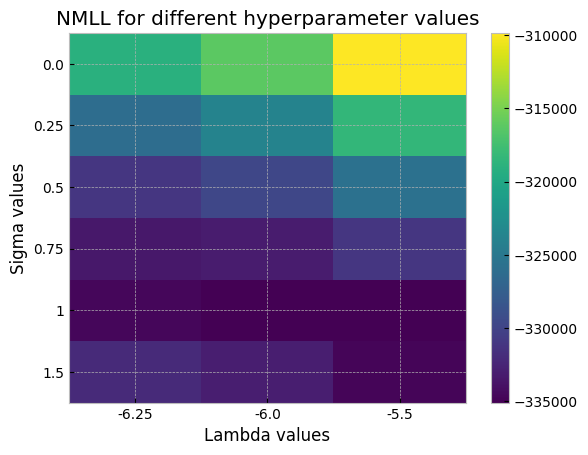

In [13]:
plt.style.use("bmh")

plt.imshow(nmll_grid.T, aspect="auto")
plt.xticks(np.arange(len(lambda_grid)), lambda_grid)
plt.yticks(np.arange(len(sigma_grid)), sigma_grid)
plt.xlabel("Lambda values")
plt.ylabel("Sigma values")
plt.title("NMLL for different hyperparameter values")
plt.colorbar()
plt.show()

We might be able to do even better by expanding the search slighly in that direction, by using the ```tune_hyperparams``` routine
in xGPR with the Powell method to further fine-tune, or by using more RFFs to more accurately estimate the NMLL. For now, though, since this is just a demo, we'll just set to the best value we found and then fit.

In [24]:
init_model.set_hyperparams(np.array([-6., 1.]), train_dset)

We use a tighter tol than usual here, since the data is noise-free
enough that small improvements in accuracy matter. (Note that
tol = 1e-8 is usually overkill however; 1e-7 is generally
tight enough).

In [25]:
init_model.num_rffs = 8192
start_time = time.time()
init_model.fit(train_dset, mode = 'cg', tol=1e-7)
end_time = time.time()
print(f"Wallclock: {end_time - start_time}")

starting fitting
Chunk 0 complete.
Chunk 10 complete.
Chunk 20 complete.
Chunk 30 complete.
Chunk 40 complete.
Chunk 50 complete.
Chunk 60 complete.
Chunk 70 complete.
Chunk 80 complete.
Chunk 90 complete.
Chunk 100 complete.
Chunk 0 complete.
Chunk 10 complete.
Chunk 20 complete.
Chunk 30 complete.
Chunk 40 complete.
Chunk 50 complete.
Chunk 60 complete.
Chunk 70 complete.
Chunk 80 complete.
Chunk 90 complete.
Chunk 100 complete.
Chunk 0 complete.
Chunk 10 complete.
Chunk 20 complete.
Chunk 30 complete.
Chunk 40 complete.
Chunk 50 complete.
Chunk 60 complete.
Chunk 70 complete.
Chunk 80 complete.
Chunk 90 complete.
Chunk 100 complete.
Chunk 0 complete.
Chunk 10 complete.
Chunk 20 complete.
Chunk 30 complete.
Chunk 40 complete.
Chunk 50 complete.
Chunk 60 complete.
Chunk 70 complete.
Chunk 80 complete.
Chunk 90 complete.
Chunk 100 complete.
Chunk 0 complete.
Chunk 10 complete.
Chunk 20 complete.
Chunk 30 complete.
Chunk 40 complete.
Chunk 50 complete.
Chunk 60 complete.
Chunk 70 comple

In [26]:
start_time = time.time()
all_preds, ground_truth = [], []
for xfile, yfile, sfile in zip(train_x_files, train_y_files, train_seqlen_files):
    ground_truth.append(np.load(yfile))
    preds = init_model.predict(np.load(xfile), np.load(sfile).astype(np.int32), get_var = False)
    all_preds.append(preds)
    
all_preds, ground_truth = np.concatenate(all_preds), np.concatenate(ground_truth)
end_time = time.time()
print(f"Wallclock: {end_time - start_time}")


print("Mean absolute error:")
print(np.round(np.mean(np.abs(all_preds - ground_truth)), 5))

Wallclock: 2.4801197052001953
Mean absolute error:
1.41641


Not bad...for a start. We're already at an MAE of about 1.4 ("chemical accuracy" is widely considered to be
1 kcal/mol). We're already outperforming the deep learning models described in the MoleculeNet paper using a simple stupid approach
(one-hot encoded atoms) that really shouldn't work as well as it did. Let's see how we can make this better using the existing features (without doing more feature engineering).

We can increase the number of random features for fitting, and /or we can further fine-tune our hyperparameters using
more RFFs. Let's do both. Normally we don't usually fine tune with significantly more RFFs than 8192 because gains
in performance are just too small (although you can). For fitting, by contrast, going up to 16384 or even 32768 RFFs can
yield some additional performance gains (although it will slow fitting down somewhat). Notice that we use the
hyperparameters we found from the grid search as a starting point.

In [27]:
init_model.num_rffs = 8192
init_model.tune_hyperparams(train_dset, tuning_method="Powell", nmll_method="exact",
                            max_iter = 40, starting_hyperparams = np.array([-6., 1.]) )

Evaluated NMLL.
Evaluated NMLL.
Evaluated NMLL.
Evaluated NMLL.
Evaluated NMLL.
Evaluated NMLL.
Evaluated NMLL.
Evaluated NMLL.
Evaluated NMLL.
Evaluated NMLL.
Evaluated NMLL.
Evaluated NMLL.
Evaluated NMLL.
Evaluated NMLL.
Evaluated NMLL.
Evaluated NMLL.
Evaluated NMLL.
Evaluated NMLL.
Evaluated NMLL.
Evaluated NMLL.
Evaluated NMLL.
Best score: -355759.9107557351


(array([-6.67864514,  1.03682873]), 21, -355759.9107557351)

In [28]:
init_model.num_rffs = 16384
init_model.fit(train_dset, mode = 'cg', tol=1e-7)

starting fitting
Chunk 0 complete.
Chunk 10 complete.
Chunk 20 complete.
Chunk 30 complete.
Chunk 40 complete.
Chunk 50 complete.
Chunk 60 complete.
Chunk 70 complete.
Chunk 80 complete.
Chunk 90 complete.
Chunk 100 complete.
Chunk 0 complete.
Chunk 10 complete.
Chunk 20 complete.
Chunk 30 complete.
Chunk 40 complete.
Chunk 50 complete.
Chunk 60 complete.
Chunk 70 complete.
Chunk 80 complete.
Chunk 90 complete.
Chunk 100 complete.
Chunk 0 complete.
Chunk 10 complete.
Chunk 20 complete.
Chunk 30 complete.
Chunk 40 complete.
Chunk 50 complete.
Chunk 60 complete.
Chunk 70 complete.
Chunk 80 complete.
Chunk 90 complete.
Chunk 100 complete.
Chunk 0 complete.
Chunk 10 complete.
Chunk 20 complete.
Chunk 30 complete.
Chunk 40 complete.
Chunk 50 complete.
Chunk 60 complete.
Chunk 70 complete.
Chunk 80 complete.
Chunk 90 complete.
Chunk 100 complete.
Chunk 0 complete.
Chunk 10 complete.
Chunk 20 complete.
Chunk 30 complete.
Chunk 40 complete.
Chunk 50 complete.
Chunk 60 complete.
Chunk 70 comple

In [29]:
start_time = time.time()
all_preds, ground_truth = [], []
for xfile, yfile, sfile in zip(test_x_files, test_y_files, test_seqlen_files):
    x, y, s = np.load(xfile), np.load(yfile), np.load(sfile)
    ground_truth.append(y)
    preds = init_model.predict(x, s, get_var = False)
    all_preds.append(preds)
    
all_preds, ground_truth = np.concatenate(all_preds), np.concatenate(ground_truth)
end_time = time.time()
print(f"Wallclock: {end_time - start_time}")

print("Mean absolute error:")
print(np.round(np.mean(np.abs(all_preds - ground_truth)), 4))

Wallclock: 0.8249120712280273
Mean absolute error:
1.2972


Text(0.5, 1.0, 'Predicted vs actual post fine-tuning,\nfitting with 16384 random features')

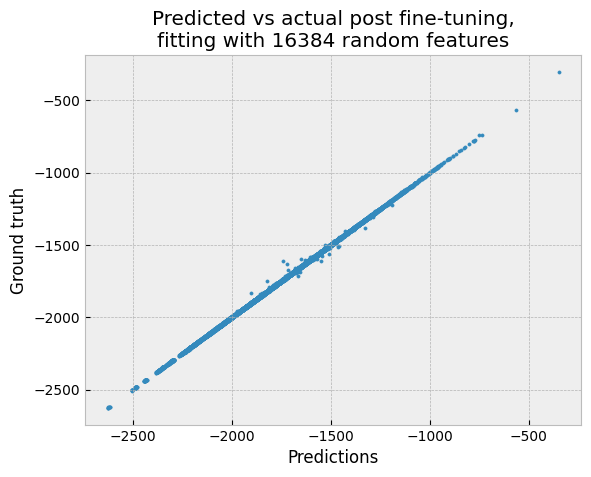

In [30]:
plt.style.use("bmh")
plt.scatter(all_preds, ground_truth, s = 5)
plt.xlabel("Predictions")
plt.ylabel("Ground truth")
plt.title("Predicted vs actual post fine-tuning,\nfitting with 16384 random features")

Retuning helped -- we're down to a mean absolute error of 1.29 kcal/mol, substantially better than any of the MoleculeNet deep learning models.

Just for fun, let's see what happens if we fit with 2x more random features. This will result in slower fitting, and will make generating predictions slower. As always, remember that increasing the number of RFFs for either tuning or
fitting provides diminishing returns -- going from 4096 to 8192 provides a more significant boost than going from 8192 to 16384 and so on.

In [31]:
init_model.num_rffs = 32768
init_model.fit(train_dset, mode = 'cg', tol=1e-7)

starting fitting
Chunk 0 complete.
Chunk 10 complete.
Chunk 20 complete.
Chunk 30 complete.
Chunk 40 complete.
Chunk 50 complete.
Chunk 60 complete.
Chunk 70 complete.
Chunk 80 complete.
Chunk 90 complete.
Chunk 100 complete.
Chunk 0 complete.
Chunk 10 complete.
Chunk 20 complete.
Chunk 30 complete.
Chunk 40 complete.
Chunk 50 complete.
Chunk 60 complete.
Chunk 70 complete.
Chunk 80 complete.
Chunk 90 complete.
Chunk 100 complete.
Chunk 0 complete.
Chunk 10 complete.
Chunk 20 complete.
Chunk 30 complete.
Chunk 40 complete.
Chunk 50 complete.
Chunk 60 complete.
Chunk 70 complete.
Chunk 80 complete.
Chunk 90 complete.
Chunk 100 complete.
Chunk 0 complete.
Chunk 10 complete.
Chunk 20 complete.
Chunk 30 complete.
Chunk 40 complete.
Chunk 50 complete.
Chunk 60 complete.
Chunk 70 complete.
Chunk 80 complete.
Chunk 90 complete.
Chunk 100 complete.
Chunk 0 complete.
Chunk 10 complete.
Chunk 20 complete.
Chunk 30 complete.
Chunk 40 complete.
Chunk 50 complete.
Chunk 60 complete.
Chunk 70 comple

In [32]:
start_time = time.time()
all_preds, ground_truth = [], []
for xfile, yfile, sfile in zip(test_x_files, test_y_files, test_seqlen_files):
    x, y, s = np.load(xfile), np.load(yfile), np.load(sfile)
    ground_truth.append(y)
    preds = init_model.predict(x, s, get_var = False)
    all_preds.append(preds)
    
all_preds, ground_truth = np.concatenate(all_preds), np.concatenate(ground_truth)
end_time = time.time()
print(f"Wallclock: {end_time - start_time}")

print("Mean absolute error:")
print(np.round(np.mean(np.abs(all_preds - ground_truth)), 4))

Wallclock: 1.7696642875671387
Mean absolute error:
1.1827


Text(0.5, 1.0, 'Predicted vs actual post fine-tuning,\nfitting with 32768 random features')

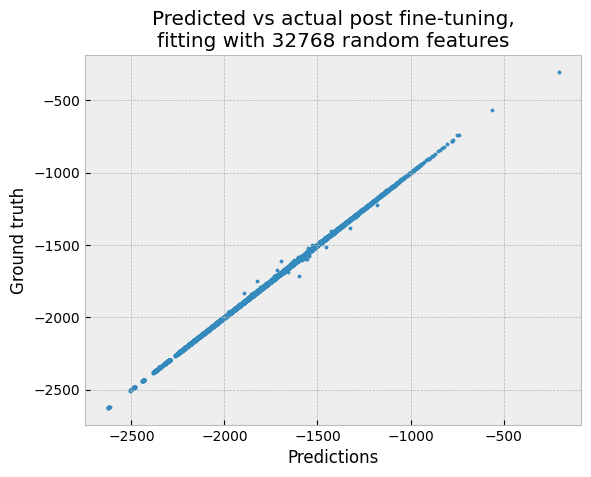

In [33]:
plt.style.use("bmh")
plt.scatter(all_preds, ground_truth, s = 5)
plt.xlabel("Predictions")
plt.ylabel("Ground truth")
plt.title("Predicted vs actual post fine-tuning,\nfitting with 32768 random features")

The mean absolute error is surprisingly close to 1 kcal/mol -- given that we're using a generic convolution kernel with one-hot encoded input. And we can still make predictions for 20,000 molecules in a couple seconds on GPU.

We can improve on this further by doing some more hyperparameter tuning
or increasing the number of fitting RFFs, but these will just provides some incremental improvement (recall that
increasing the number of random features provides diminishing returns). So, further tweaking might give us some additional small improvement, but it's very unlikely to get us down to 0.5 or 0.25 kcal/mol (if that was our goal). Once we've fine-tuned with 8192 RFFs and fitted using a decent number of RFFs (e.g. 16384), further improvements from "tweaking" are likely to be modest.

To get a much larger improvement we need either a different kernel or (more likely) a more
informative representation of the input molecules. The representation
we used here discards all information about bond angles and is very uninformative.
We've been able to reach < 0.17 kcal/mol using SOAP features
(and there are other ways to do this as well). The same interestingly
is true in this case for deep learning models -- deep learning models provided with
uninformative representations (e.g. one hot encoding) often perform much worse than
xGPR does here (see the MoleculeNet paper for example). So, for both deep learning and
GPs, predicting energy with MAE << 1 kcal/mol seems to require informative features.